# 细胞群落计数

In [1]:
from imp import reload
from IPython.display import display, Markdown, Latex
from tqdm import tqdm
import seaborn as sns
import math
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure,data,color
from scipy.spatial.distance import cdist
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

def set_style():
    sns.set_style('whitegrid')
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    pd.options.display.max_columns = 300
    pd.options.display.max_rows = 1000
    # plt.rcParams['figure.dpi'] = 200
    sns.set_palette('muted')  # 调色板颜色温和
    sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1})

set_style()

def plt_show(img_ndarray, figsize=(24,6), gray=True):
    """默认画灰度图"""
    plt.figure(figsize=figsize)
    plt.grid(False)
    if gray:
        plt.imshow(img_ndarray, 'gray')
    else:
        plt.imshow(img_ndarray)
    plt.show()

## 准确率和召回率分析

细胞群落计算标准：
    一般定义CFU，是说细胞在体外增殖6次形成的集落，也就是50个细胞以上。按照我之前对CFU定义条件的摸索实验得出的结论就是直径小于0.1cm的颜色较深群落，以及直径在0.1cm-0.2cm之间的群落，直径大于0.2的颜色较深的群落。
    
    颜色的深浅是由聚集的细胞数以及聚集程度决定的，一般克隆群的生长都是呈聚集生长，聚集程度较高，这样的克隆群染完后颜色就很深。
    
检测的标准:
    
>1)直径小于0.1cm的颜色较深群落，2)以及直径在0.1cm-0.2cm之间的群落，2)直径大于0.2的颜色较深的群落。

    这个定义的话应该只需要关注"直径小于0.1cm的颜色"和"直径大于0.2的颜色"就可以。一般大多数直径大于0.2cm的群落，它的颜色都很深了，只是有少部分细胞没有克隆能力但是在生长过程中逐渐靠近，这样染出的颜色肉眼也能看出，但颜色较浅。

**图一：**

| Pre\T | P:187 |N |
| :-----:| :----: | :----: |
| P:181 | TP:175 | FP:6 |
| N:20 | FN:12 | TN:0 |

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$Acc = \frac{TP+TN}{Total}=\frac{175}{175+12+6}\simeq 0.91 $;$Pre = \frac{TP}{TP+FP}=\frac{175}{181}\simeq 0.97$;
$Rec = \frac{TP}{TP+FN}=\frac{175}{187}\simeq 0.94$

如何解释TN：首先，我们不想检测某一类物体，然后我们的检测器就没有检测它，我们就说检测器正确地处理了这一类物体

**图二：**


| Pre\T | P:296 |N |
| :-----:| :----: | :----: |
| P:270 | TP:265 | FP:5 |
| N: | FN:31 | TN:0 |

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$Acc = \frac{TP+TN}{Total}=\frac{265}{265+31+5}\simeq 0.88 $;$Pre = \frac{TP}{TP+FP}=\frac{265}{270}\simeq 0.98$;
$Rec = \frac{TP}{TP+FN}=\frac{265}{296}\simeq 0.90$

注：集落标注数量受人的主观因素影响

**图三：**


| Pre\T | P:308 |N |
| :-----:| :----: | :----: |
| P:333 | TP:302 | FP:31 |
| N: | FN:6 | TN:0 |

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$Acc = \frac{TP+TN}{Total}=\frac{302}{302+31+6}\simeq 0.89 $;$Pre = \frac{TP}{TP+FP}=\frac{302}{333}\simeq 0.90$;
$Rec = \frac{TP}{TP+FN}=\frac{302}{308}\simeq 0.98$

**图四：**

| Pre\T | P:313 |N |
| :-----:| :----: | :----: |
| P:308 | TP:298 | FP:10 |
| N:20 | FN:25 | TN:0 |

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$Acc = \frac{TP+TN}{Total}=\frac{167}{167+14+20}\simeq 0.89 $;$Pre = \frac{TP}{TP+FP}=\frac{298}{308}\simeq 0.96$;
$Rec = \frac{TP}{TP+FN}=\frac{298}{313}\simeq 0.95$

**第一批图片的平均检测准确率为:**
>(0.91+0.88+0.88+0.89)/4 = 0.89

In [21]:
# 平均查全率
(0.95+0.98+0.90+0.94)/4

0.9425

In [22]:
# 平均查准率
(0.96 + 0.90 + 0.98 + 0.97)/4

0.9524999999999999

## 第三次算法优化


针对第一批图片检测的反馈结果，分析算法的改进办法：

>已知培养皿外径为10cm，由这个比例信息，增加标准面积修正参数:
>>1）轮廓总面积除以轮廓平均面积; &emsp;
>>2）单个轮廓的比例面积


### 高斯滤波

In [2]:
img = cv2.imread('data/cells1/308-1.jpg')
h,w,c = img.shape  # opencv 读取的图片格式：（h, w, c) 
print(h,w,c)
plt_show(img, figsize=(15,15))

961 963 3


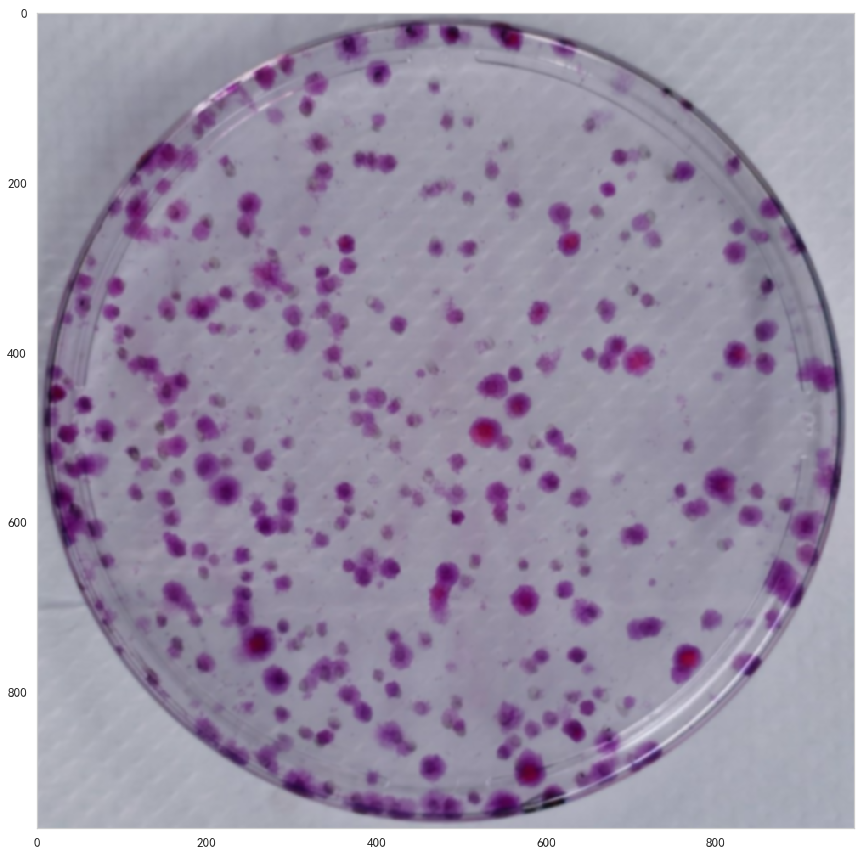

In [4]:
img = cv2.GaussianBlur(img, (5, 5), 1)
plt_show(img, figsize=(15,15))

### 类HsvCntsFilter| 负责拿到颜色轮廓 

In [23]:
class HsvCntsFilter:
    """从原始图片经过HSV颜色分割拿到合适的轮廓
    inp: img path
    out: contours of cell populations and resized img
    1) 读入图片
    2）缩放
    3）hsv滤波
    4）初步筛选轮廓
    5）保存处理后的轮廓和图形
    """
    def __init__(self):
        self.img = None
        self.resized_img = None
        self.cnts = None
        
    def process(self, img_path):
        """处理流程
        1）图像缩放--2）高斯平滑--3)颜色分割--4）轮廓过滤
        """
        # 读入图片
        self.img = cv2.imread(img_path)
        # 将图片大小等比缩放到h=900, w=900*scale
        self.resized_img = self.resize(self.img)
        # 高斯平滑  是否利于图形的饱和度分析呢？
        self.resized_img = cv2.cvtColor(self.resized_img, cv2.COLOR_BGR2RGB)
        # self.resized_img = cv2.GaussianBlur(self.resized_img, (5, 5), 0)  #  核的大小核（5，5）和标准差如何优化 
        # 颜色分割
        mask = self._hsv_creterions(self.resized_img)
        #plt_show(mask, figsize=(15,15))  # test used
        # 拿到轮廓
        contours, hierarchy = cv2.findContours(mask, 
                                       cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_NONE)
        # 初步过滤掉一些轮廓
        self.cnts = self._fileter_cnts(contours)
        #cv2.drawContours(self.resized_img, self.cnts, -1, (255,255,0), 1)  # 可视化 cnts (optional)
        #plt_show(self.resized_img, figsize=(20,15))  # optional
        
    def _hsv_creterions(self, img, low=[0, 80, 50], up=[240, 200, 220]):
        """这里返回的轮廓是后续群落计数的基础
        直接返回过滤后的全图轮廓
        """
        # 1 颜色转换
        img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        # 2 阈值过滤
        low_purple = np.array(low)   
        high_purple = np.array(up)
        mask = cv2.inRange(img_hsv, low_purple, high_purple)

        # 3 膨胀处理二值轮廓掩膜  这一步的处理 抑制了培养皿边缘的噪音
        kernel = np.ones((3, 3), np.uint8)
        mask_dilate = cv2.dilate(mask, kernel, iterations=1)
        # 4 返回过滤后的二值轮廓图像
        return mask_dilate
    
    def resize(self, img, fixed_size=900):
        h, w, _ = img.shape
        nh, nw = fixed_size, int(fixed_size * (w / h))  
        img_resize = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_CUBIC)
        return img_resize
    
    def _fileter_cnts(self, contours, min_area=70):
        """初步过滤掉一些轮廓
        这里可以进一步添加规则 得到较优质的轮廓
        """
        filtered_cnts = []
        for cnt in contours:
            cnt_area = cv2.contourArea(cnt)
            #cnt_length =  cv2.arcLength(cnt,True)
            #area_length_ratio = cnt_area / cnt_length
            #if cnt_area > min_area and area_length_ratio > 0.5:  # 所有的轮廓都经过了一次膨胀处理，这里的轮廓面积选择条件要考虑到这一点
            if cnt_area > min_area:
                x,y,w,h = cv2.boundingRect(cnt)
                if 0.25 < w/h <4:  # 不要很扁的也不要很高的轮廓 
                    filtered_cnts.append(cnt)
        return filtered_cnts
    
    def draw_index(self):
        """画出轮廓的索引便于逐个分析轮廓"""
        img_draw = self.resized_img.copy()
        for idx, cnt in enumerate(self.cnts):  # 这里索引的顺序是self.cnts的顺序
            try:
                cv2.drawContours(img_draw, cnt, -1, (255,255,0), 1)
                
                M = cv2.moments(cnt)
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                cv2.circle(img_draw, (cx, cy), 2, (0, 255, 0), 1)
                cv2.putText(img_draw, str(idx), (cx + 5, cy + 5),
                        cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0, 255, 255), 1)
            except:
                print("missing %d" %idx)
        plt_show(img_draw, figsize=(15,15))

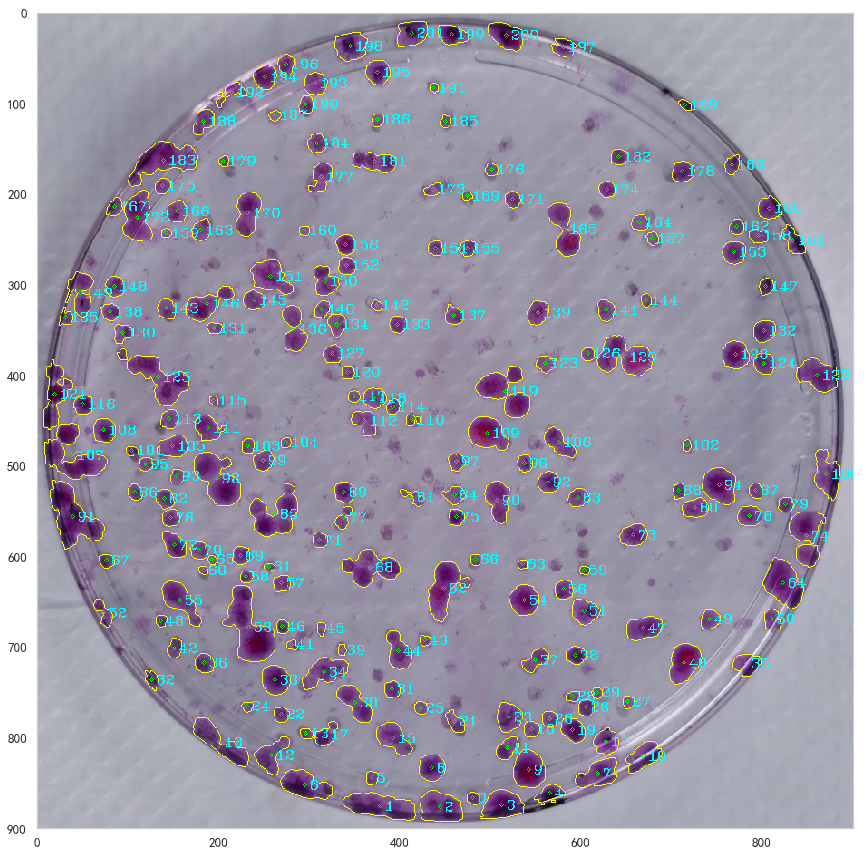

In [19]:
img_path = 'data/cells1/308-1.jpg'
hsv_filter = HsvCntsFilter()
hsv_filter.process(img_path)
hsv_filter.draw_index()

In [69]:
# 轮廓分析
def cont_df_analysis(contours):
    
    print('轮廓总个数:', np.array(contours).shape[0])
    cont_arclength = []  # 轮廓周长
    hull = []  # 轮廓凸包
    hull_arclength = []  # 凸包周长
    cnt_boundingrect_w = []
    cnt_boundingrect_h = []
    for i in range(len(contours)):
        hull.append(cv2.convexHull(contours[i], True))  # 轮廓凸包
        cont_arclength.append(cv2.arcLength(contours[i], True))  # 轮廓周长
        hull_arclength.append(cv2.arcLength(hull[i], True))  # 轮廓凸包周长
        x,y, w, h = cv2.boundingRect(contours[i])
        cnt_boundingrect_w.append(w)
        cnt_boundingrect_h.append(h)
    cont_area = []
    hull_area = []
    for i in range(len(contours)):
        cont_area.append(cv2.contourArea(contours[i]))
        hull_area.append(cv2.contourArea(hull[i]))

    df_area = pd.DataFrame({
        'area': cont_area,
        'area_hull': hull_area,
        'arclength': cont_arclength,
        'arclength_hull': hull_arclength,
        'rect_w': cnt_boundingrect_w,
        'rect_h': cnt_boundingrect_h,
    })

    df_area['r1'] = df_area['area'] / df_area['arclength']  # 轮廓面积 / 轮廓周长 = 面积周长比
    df_area['r2'] = df_area['arclength'] / df_area['arclength_hull']
    df_area['r3'] = df_area['rect_w'] / df_area['rect_h']
    df_area['d1'] = df_area['area_hull'] - df_area['area']  # 凸包的面积 - 轮廓的面积
   
    return df_area

In [81]:
hsv_cnts = hsv_filter.cnts
df_area_filtered = cont_df_analysis(hsv_cnts)
# df_area_filtered.sort_values("r1")
df_area_filtered

轮廓总个数: 181


area  area_hull    arclength  arclength_hull  rect_w  rect_h  \
0      118.5      128.5    44.727922       42.735604      13      14   
1       82.0      108.5    67.112698       62.931898      28      14   
2      383.0      680.0   161.053823      115.823544      46      27   
3      268.0      289.5    69.455844       62.095587      22      18   
4     5917.5    25051.0  1628.413337      948.329466     450     116   
5      458.0      590.5   132.225396       94.149537      26      36   
6      206.0      278.0    77.455844       66.593364      25      17   
7      139.5      155.0    51.213203       47.988357      18      14   
8      211.0      259.5    77.455844       65.347827      15      26   
9      705.0      865.0   187.338094      132.954756      49      41   
10     179.5      221.5    67.213203       58.009566      20      18   
11     131.5      193.0    74.384776       51.549379      16      18   
12     180.0      243.0    73.112698       59.678040      18      21   
13     165.5      190.5    55.213203       51.742836      15      19   
14     212.5      273.0    84.183766       67.594503      15      28   
15     139.5      163.0    54.041630       49.282658      13      19   
16     226.5      256.0    71.213203       61.246180      21      16   
17     183.5      206.5    58.041630       53.631206      19      16   
18     195.0      232.0    70.627417       56.676669      18      19   
19      96.0       98.0    37.313708       36.705481      12      11   
20     155.0      161.5    50.970562       49.492060      19      12   
21      98.0      107.0    42.970562       38.475235      12      13   
22     175.0      345.0   143.681239      124.201534      35      51   
23     144.0      158.5    50.970562       47.619336      16      15   
24      88.0       93.0    36.970562       35.788726      12      12   
25     165.5      180.5    54.384776       49.761610      15      17   
26     134.5      166.0    57.213203       48.561446      15      17   
27     159.5      233.0    70.041630       58.659548      18      19   
28     149.5      160.0    51.899495       49.017864      17      13   
29     116.0      152.0    56.970562       50.252651      17      15   
30     186.0      197.5    53.798990       51.883899      18      15   
31     695.0      886.5   150.225396      119.566531      48      27   
32     142.0      169.5    53.798990       48.472275      17      15   
33     109.0      116.0    40.970562       39.480903      13      13   
34      85.5       92.5    37.556349       35.418464      11      13   
35      86.0      117.5    72.284271       67.833274      13      31   
36     442.0      515.0   107.597979       90.718965      27      33   
37     121.5      144.0    55.213203       47.582640      20      11   
38     105.0      161.5    68.627417       49.391689      13      20   
39     134.5      155.5    50.727922       45.628969      15      15   
40     130.0      141.5    46.142135       43.947277      13      15   
41     101.5      152.0    59.213203       48.758855      15      17   
42     118.5      127.0    43.556349       41.936579      13      14   
43     139.0      146.5    47.313708       46.272052      16      12   
44     205.0      293.0    88.284271       70.762853      23      24   
45     166.5      175.0    51.213203       48.763714      14      17   
46     162.0      179.0    53.798990       49.746291      18      14   
47     155.5      165.0    49.556349       47.236492      14      16   
48      96.5      105.0    40.727922       37.703716      13      11   
49    3461.5     6437.5   597.144223      418.767104      81     181   
50     300.5      350.5    79.698484       70.868690      19      27   
51     222.0      262.0    71.798990       63.633329      15      24   
52     195.0      214.0    59.798990       55.537460      20      15   
53      81.5      112.5    55.556349       51.224196      10      23   
54     121.5      174.0    62.041630       50.15

In [82]:
df_area_filtered.describe()

area     area_hull    arclength  arclength_hull      rect_w  \
count    181.000000    181.000000   181.000000      181.000000  181.000000   
mean     365.093923    853.353591   102.685754       78.024372   25.149171   
std     1257.264853   4615.559534   238.643532      130.642433   52.540618   
min       80.500000     88.500000    35.313708       34.527336   10.000000   
25%      118.500000    141.500000    50.727922       45.629611   14.000000   
50%      157.000000    186.500000    60.284271       51.905259   17.000000   
75%      227.500000    284.500000    77.497474       67.364176   21.000000   
max    14683.500000  50897.500000  2452.275378     1211.145993  558.000000   

           rect_h          r1          r2          r3            d1  
count  181.000000  181.000000  181.000000  181.000000    181.000000  
mean    24.359116    2.810191    1.159744    1.031896    488.259669  
std     37.367816    0.771108    0.140295    0.425126   3380.435002  
min     10.000000    1.127916    1.016558    0.285393      2.000000  
25%     14.000000    2.368586    1.065617    0.772727     13.500000  
50%     18.000000    2.712156    1.118531    1.000000     27.000000  
75%     23.000000    3.178305    1.208747    1.195122     60.500000  
max    445.000000    5.987704    2.024756    3.879310  36214.000000

### 类PopuCntAnalyser| 分析颜色轮廓中群落的个数

In [24]:
class PopuCntAnalyser:
    """分析每个轮廓中一共有几个群落
    
    先画一些辅助图以bin_开头
    没有连接在一起的群落可以不用这个函数分析
    """
    def __init__(self, counters, img_src):
        self.cnts = counters  # 传进来所有的轮廓
        self.img = img_src
        self.total_popu = 0
        self.h, self.w, _ = img_src.shape

    def __getitem__(self, index):
        count = 0
#         img_draw = self.img.copy()  # 每次把轮廓画到不同的图上 test used
        img_draw = self.img  # 每次都把轮廓画到同一张图上
        # 1 首先直接画出 这个 轮廓
        cnt = self.cnts[index]  # 轮廓
        cv2.drawContours(img_draw, cnt, -1, (255, 255, 0), 1)  # 将轮廓cnt画到图img_draw上
        #print(cv2.contourArea(cnt))
        # -----------------------------------------------------------------
        #                                分析
        # -----------------------------------------------------------------
        cnt_area = cv2.contourArea(cnt)
        #print(cnt_area)
        if cnt_area <= 800:  # 一个小的群落
            popu_num = 1 
        elif 800 < cnt_area <= 4000: # 分析连接在一起的轮廓中有几个群落  大轮廓 - 小轮廓 的图
            bin_sub_thresh = self._bin_count_with_hull(cnt)  
            popu_num = self.cont_popu_cnts(bin_sub_thresh)
            if popu_num == 0:  # 这个轮廓的计数凹轮廓为0 本身是一个大的圆润的轮廓
                popu_num += 1
        else:
            popu_num = self._bin_count_big_popu(cnt)
            #print(popu_num)
        # 4 把群落的个数写在轮廓旁边
        self.draw_number(img_draw, cnt, popu_num)
        # 5 累计所有的群落数
        self.total_popu += popu_num
        #single_popu_conts = cv2.drawContours(img_draw, popu_acount, -1, (255, 0, 0), 1)
        #self._draw_index(cnt, index)
        #plt_show(img_draw, figsize=(20, 15))
        
    def cont_popu_cnts(self, img_gray, min_area=8):
        """在生成轮廓的同时，过滤一些面积很小的轮廓
        args:
            img_gray:处理过的二值图像，包含用于计数的轮廓
        ret:
            good_cnts: 计数轮廓
        TODO：这个地方还可以做一些优化
        """
        good_cnts = []
        cnts, _ = cv2.findContours(img_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for cnt in cnts:
            area = cv2.contourArea(cnt)
            # print(area)
            if area > min_area:  # 对凹的计数轮廓的面积限定
                good_cnts.append(cnt)
        return len(good_cnts)
    
    def draw_count_cnts(self, img, cnts):
        """辅助函数：画出计数轮廓 用红色线"""
        cv2.drawContours(img, cnts, -1, (255, 0, 0), 1)
        
    def draw_number(self, img, cnt, string):
        """将轮廓中群落的个数 写在轮廓旁边"""
        M = cv2.moments(cnt)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        cv2.circle(img, (cx, cy), 2, (0, 255, 0), cv2.FILLED)
        cv2.putText(img, str(string), (cx + 5, cy - 10),
                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 255), 1)
        
    def draw_index(self, cnt, index):
        """辅助函数：画出轮廓的索引用于后续分析"""
        M = cv2.moments(cnt)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        cv2.circle(self.img, (cx, cy), 2, (0, 255, 0), 1)
        cv2.putText(self.img, str(index), (cx + 5, cy + 5),
                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0, 255, 255), 1)
    
    def show_cnts(self):
        plt_show(self.img, figsize=(20, 15))

    def bin_contours(self, cnt):
        """在二值图上画出轮廓的填充图"""
        img_bin = np.zeros((self.h, self.w))
        draw_bin = cv2.drawContours(img_bin, [cnt], -1, [255, 255, 255], cv2.FILLED)
        return draw_bin
        
    def bin_enclose_circle(self, cnt):
        """在二值图上画出轮廓内接圆的填充图"""
        img_bin = np.zeros((self.h, self.w))
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(radius)
        draw_bin = cv2.circle(img_bin, center, radius, (255, 255, 255), cv2.FILLED)
        return draw_bin
    
    def bin_hull(self, cnt):
        """在二值图上画出轮廓凸包的填充图"""
        img_bin = np.zeros((self.h, self.w))
        hull = cv2.convexHull(cnt, False)
        res = cv2.drawContours(img_bin, [hull], -1, (255, 255, 255), cv2.FILLED)
        return res
    
    def _bin_count_with_circle(self, cnt):
        """使用轮廓外接圆减去轮廓后剩下的图形作为计数轮廓"""
        bin_circle = self.bin_enclose_circle(cnt)
        bin_cnt = self.bin_contours(cnt)
        bin_sub = cv2.subtract(bin_circle, bin_cnt)
        bin_sub = bin_sub.astype(np.uint8)
        _, bin_sub_thresh = cv2.threshold(bin_sub, 50, 255, cv2.THRESH_BINARY)
  
        #print(type(bin_sub), bin_sub.shape, bin_sub)
        #plt_show(bin_circle, figsize=(20,15))
        #plt_show(bin_cnt, figsize=(20,15))
        #plt_show(bin_sub_thresh, figsize=(20,15))
        return bin_sub_thresh

    def _bin_count_with_hull(self, cnt):
        """使用轮廓外接凸包减去轮廓后剩下的图形作为计数轮廓
        inp：轮廓列表
        out: 凹轮廓二值图
        """
        bin_hull = self.bin_hull(cnt)
        bin_cnt = self.bin_contours(cnt)
        bin_sub = cv2.subtract(bin_hull, bin_cnt)
        bin_sub = bin_sub.astype(np.uint8)  # .astype(np.unit8) np数值类型转化
        _, bin_sub_thresh = cv2.threshold(bin_sub, 50, 255, cv2.THRESH_BINARY)
        
#         plt_show(bin_hull, figsize=(20,15))
#         plt_show(bin_cnt, figsize=(20,15))
#         plt_show(bin_sub_thresh, figsize=(20,15))
        return bin_sub_thresh  

    def _bin_count_big_popu(self, cnt):
        """这里首要考虑的事情是腐蚀轮廓拉开连在一起的群落"""
        accumulate_popu_num = 0
        bin_cnt = self.bin_contours(cnt)
        #plt_show(bin_cnt, figsize=(20,15))
        
        kernel = np.ones((3, 3), np.uint8)
        bin_cnt_erode = cv2.erode(bin_cnt, kernel, iterations=4)
        #plt_show(bin_cnt_erode, figsize=(20,15))
        
        bin_cnt_erode = bin_cnt_erode.astype(np.uint8)
#         _, bin_cnt_erode_thresh = cv2.threshold(bin_cnt_erode, 50, 255, cv2.THRESH_BINARY)
#         plt_show(bin_cnt_erode_thresh, figsize=(20,15))
        
#         bin_cnt_erode = bin_cnt_erode.astype(np.uint8)
        cnts, _ = cv2.findContours(bin_cnt_erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        #print("轮廓个数：", len(cnts))
        for cnt in cnts:
            cnt_area = cv2.contourArea(cnt)
            #print(cnt_area)
            if cnt_area > 6000:  # 如果腐蚀之后轮廓还是很大就直接用面积近似计算
                popu_num = math.ceil(cnt_area / 1000)
                # TODO：面积处理  是不是要做递归处理？
                accumulate_popu_num += popu_num
            else:  # 仍然使用凹轮廓计数
                img_bin = self._bin_count_with_hull(cnt)
                #plt_show(img_bin,  figsize=(20,15))
                popu_num = self.cont_popu_cnts(img_bin)
                if popu_num == 0:  # 一个很圆润的轮廓可能没有 凹的计数轮廓
                    popu_num += 1
                accumulate_popu_num += popu_num
        #kernel = np.ones((3,3),np.uint8) 
        #bin_cnt_opening = cv2.morphologyEx(bin_cnt_erode, cv2.MORPH_OPEN, kernel)
        
        #plt_show(bin_cnt_erode_thresh, figsize=(20,15))
        #plt_show(bin_cnt, figsize=(20,15))
        #plt_show(bin_sub_thresh, figsize=(20,15))
        #print('大轮廓中群落的个数为', accumulate_popu_num)
        return accumulate_popu_num

### 综合计数:

In [2]:
class HsvCntsFilter:
    """从原始图片经过HSV颜色分割拿到合适的轮廓
    inp: img path
    out: contours of cell populations and resized img
    1) 读入图片
    2）缩放
    3）hsv滤波
    4）初步筛选轮廓
    5）保存处理后的轮廓和图形
    """
    def __init__(self, config):
        self.img = None
        self.resized_img = None
        self.cnts = None
        self.config = config
        
    def process(self, img_path):
        """处理流程
        1）图像缩放--2）高斯平滑--3)颜色分割--4）轮廓过滤
        """
        # 读入图片
        self.img = cv2.imread(img_path)
        # 将图片大小等比缩放到h=900, w=900*scale
        self.resized_img = self.resize(self.img)
        # 高斯平滑  是否利于图形的饱和度分析呢？
        self.resized_img = cv2.cvtColor(self.resized_img, cv2.COLOR_BGR2RGB)
        self.resized_img = cv2.GaussianBlur(self.resized_img, (5, 5), 0)  #  核的大小核（5，5）和标准差如何优化 
        # 颜色分割
        mask = self._hsv_creterions(self.resized_img, low=self.config["hsv_low"], up=self.config["hsv_up"])
        #plt_show(mask, figsize=(15,15))  # test used
        # 拿到轮廓
        contours, hierarchy = cv2.findContours(mask, 
                                       cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_NONE)
        # 初步过滤掉一些轮廓
        self.cnts = self._fileter_cnts(contours)
        #cv2.drawContours(self.resized_img, self.cnts, -1, (255,255,0), 1)  # 可视化 cnts (optional)
        #plt_show(self.resized_img, figsize=(20,15))  # optional
        
    def _hsv_creterions(self, img, low, up):
        """这里返回的轮廓是后续群落计数的基础
        直接返回过滤后的全图轮廓
        """
        # 1 颜色转换
        img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        # 2 阈值过滤
        low_purple = np.array(low)   
        high_purple = np.array(up)
        mask = cv2.inRange(img_hsv, low_purple, high_purple)

        # 3 膨胀处理二值轮廓掩膜  这一步的处理 抑制了培养皿边缘的噪音
        kernel = np.ones((3, 3), np.uint8)
        mask_dilate = cv2.dilate(mask, kernel, iterations=1)
        # 4 返回过滤后的二值轮廓图像
        return mask_dilate
    
    def resize(self, img, fixed_size=900):
        h, w, _ = img.shape
        nh, nw = fixed_size, int(fixed_size * (w / h))  
        img_resize = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_CUBIC)
        return img_resize
    
    def _fileter_cnts(self, contours, min_area=70):
        """初步过滤掉一些轮廓
        这里可以进一步添加规则 得到较优质的轮廓
        """
        filtered_cnts = []
        for cnt in contours:
            cnt_area = cv2.contourArea(cnt)
            #cnt_length =  cv2.arcLength(cnt,True)
            #area_length_ratio = cnt_area / cnt_length
            #if cnt_area > min_area and area_length_ratio > 0.5:  # 所有的轮廓都经过了一次膨胀处理，这里的轮廓面积选择条件要考虑到这一点
            if cnt_area > min_area:
                x,y,w,h = cv2.boundingRect(cnt)
                if 0.25 < w/h <4:  # 不要很扁的也不要很高的轮廓 
                    filtered_cnts.append(cnt)
        return filtered_cnts
    
    def draw_index(self):
        """画出轮廓的索引便于逐个分析轮廓"""
        img_draw = self.resized_img.copy()
        for idx, cnt in enumerate(self.cnts):  # 这里索引的顺序是self.cnts的顺序
            try:
                cv2.drawContours(img_draw, cnt, -1, (255,255,0), 1)
                
                M = cv2.moments(cnt)
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                cv2.circle(img_draw, (cx, cy), 2, (0, 255, 0), 1)
                cv2.putText(img_draw, str(idx), (cx + 5, cy + 5),
                        cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0, 255, 255), 1)
            except:
                print("missing %d" %idx)
        plt_show(img_draw, figsize=(15,15))
  
    
class PopuCntAnalyser:
    """分析每个轮廓中一共有几个群落
    
    先画一些辅助图以bin_开头
    没有连接在一起的群落可以不用这个函数分析
    """
    def __init__(self, counters, img_src, config):
        self.config = config
        self.cnts = counters  # 传进来所有的轮廓
        self.img = img_src
        self.total_popu = 0
        self.h, self.w, _ = img_src.shape

    def __getitem__(self, index):
        count = 0
#         img_draw = self.img.copy()  # 每次把轮廓画到不同的图上 test used
        img_draw = self.img  # 每次都把轮廓画到同一张图上
        # 1 首先直接画出 这个 轮廓
        cnt = self.cnts[index]  # 轮廓
        cv2.drawContours(img_draw, cnt, -1, (255, 255, 0), 1)  # 将轮廓cnt画到图img_draw上
        #print(cv2.contourArea(cnt))
        # -----------------------------------------------------------------
        #                                分析
        # -----------------------------------------------------------------
        cnt_area = cv2.contourArea(cnt)
        #print(cnt_area)
        if cnt_area <= 800:  # 一个小的群落
            popu_num = 1 
        elif 800 < cnt_area <= 4000: # 分析连接在一起的轮廓中有几个群落  大轮廓 - 小轮廓 的图
            bin_sub_thresh = self._bin_count_with_hull(cnt)  
            popu_num = self.cont_popu_cnts(bin_sub_thresh)
            if popu_num == 0:  # 这个轮廓的计数凹轮廓为0 本身是一个大的圆润的轮廓
                popu_num += 1
        else:
            popu_num = self._bin_count_big_popu(cnt)
            #print(popu_num)
        # 4 把群落的个数写在轮廓旁边
        self.draw_number(img_draw, cnt, popu_num)
        # 5 累计所有的群落数
        self.total_popu += popu_num
        #single_popu_conts = cv2.drawContours(img_draw, popu_acount, -1, (255, 0, 0), 1)
        #self._draw_index(cnt, index)
        #plt_show(img_draw, figsize=(20, 15))
        
    def cont_popu_cnts(self, img_gray):
        """在生成轮廓的同时，过滤一些面积很小的轮廓
        args:
            img_gray:处理过的二值图像，包含用于计数的轮廓
        ret:
            good_cnts: 计数轮廓
        TODO：这个地方还可以做一些优化
        """
        good_cnts = []
        cnts, _ = cv2.findContours(img_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for cnt in cnts:
            area = cv2.contourArea(cnt)
            # print(area)
            if area > self.config["flt_min_area"]:  # 对凹的计数轮廓的面积限定
                good_cnts.append(cnt)
        return len(good_cnts)
    
    def draw_count_cnts(self, img, cnts):
        """辅助函数：画出计数轮廓 用红色线"""
        cv2.drawContours(img, cnts, -1, (255, 0, 0), 1)
        
    def draw_number(self, img, cnt, string):
        """将轮廓中群落的个数 写在轮廓旁边"""
        M = cv2.moments(cnt)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        cv2.circle(img, (cx, cy), 2, (0, 255, 0), cv2.FILLED)
        cv2.putText(img, str(string), (cx + 5, cy - 10),
                    cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 255), 1)
        
    def draw_index(self, cnt, index):
        """辅助函数：画出轮廓的索引用于后续分析"""
        M = cv2.moments(cnt)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        cv2.circle(self.img, (cx, cy), 2, (0, 255, 0), 1)
        cv2.putText(self.img, str(index), (cx + 5, cy + 5),
                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0, 255, 255), 1)
    
    def show_count_result(self):
        cv2.putText(self.img, str(self.total_popu), (50, 80),
                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 3, (255, 255, 0), 3)
        plt_show(self.img, figsize=(10, 10))

    def bin_contours(self, cnt):
        """在二值图上画出轮廓的填充图"""
        img_bin = np.zeros((self.h, self.w))
        draw_bin = cv2.drawContours(img_bin, [cnt], -1, [255, 255, 255], cv2.FILLED)
        return draw_bin
        
    def bin_enclose_circle(self, cnt):
        """在二值图上画出轮廓内接圆的填充图"""
        img_bin = np.zeros((self.h, self.w))
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(radius)
        draw_bin = cv2.circle(img_bin, center, radius, (255, 255, 255), cv2.FILLED)
        return draw_bin
    
    def bin_hull(self, cnt):
        """在二值图上画出轮廓凸包的填充图"""
        img_bin = np.zeros((self.h, self.w))
        hull = cv2.convexHull(cnt, False)
        res = cv2.drawContours(img_bin, [hull], -1, (255, 255, 255), cv2.FILLED)
        return res
    
    def _bin_count_with_circle(self, cnt):
        """使用轮廓外接圆减去轮廓后剩下的图形作为计数轮廓"""
        bin_circle = self.bin_enclose_circle(cnt)
        bin_cnt = self.bin_contours(cnt)
        bin_sub = cv2.subtract(bin_circle, bin_cnt)
        bin_sub = bin_sub.astype(np.uint8)
        _, bin_sub_thresh = cv2.threshold(bin_sub, 50, 255, cv2.THRESH_BINARY)
  
        #print(type(bin_sub), bin_sub.shape, bin_sub)
        #plt_show(bin_circle, figsize=(20,15))
        #plt_show(bin_cnt, figsize=(20,15))
        #plt_show(bin_sub_thresh, figsize=(20,15))
        return bin_sub_thresh

    def _bin_count_with_hull(self, cnt):
        """使用轮廓外接凸包减去轮廓后剩下的图形作为计数轮廓
        inp：轮廓列表
        out: 凹轮廓二值图
        """
        bin_hull = self.bin_hull(cnt)
        bin_cnt = self.bin_contours(cnt)
        bin_sub = cv2.subtract(bin_hull, bin_cnt)
        bin_sub = bin_sub.astype(np.uint8)  # .astype(np.unit8) np数值类型转化
        _, bin_sub_thresh = cv2.threshold(bin_sub, 50, 255, cv2.THRESH_BINARY)
        
#         plt_show(bin_hull, figsize=(20,15))
#         plt_show(bin_cnt, figsize=(20,15))
#         plt_show(bin_sub_thresh, figsize=(20,15))
        return bin_sub_thresh  

    def _bin_count_big_popu(self, cnt):
        """这里首要考虑的事情是腐蚀轮廓拉开连在一起的群落"""
        accumulate_popu_num = 0
        bin_cnt = self.bin_contours(cnt)
        #plt_show(bin_cnt, figsize=(20,15))
        
        kernel = np.ones((3, 3), np.uint8)
        bin_cnt_erode = cv2.erode(bin_cnt, kernel, iterations=4)
        #plt_show(bin_cnt_erode, figsize=(20,15))
        
        bin_cnt_erode = bin_cnt_erode.astype(np.uint8)
#         _, bin_cnt_erode_thresh = cv2.threshold(bin_cnt_erode, 50, 255, cv2.THRESH_BINARY)
#         plt_show(bin_cnt_erode_thresh, figsize=(20,15))
        
#         bin_cnt_erode = bin_cnt_erode.astype(np.uint8)
        cnts, _ = cv2.findContours(bin_cnt_erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        #print("轮廓个数：", len(cnts))
        for cnt in cnts:
            cnt_area = cv2.contourArea(cnt)
            #print(cnt_area)
            if cnt_area > 6000:  # 如果腐蚀之后轮廓还是很大就直接用面积近似计算
                popu_num = math.ceil(cnt_area / self.config["count_mean_area"])
                # TODO：面积处理  是不是要做递归处理？
                accumulate_popu_num += popu_num
            else:  # 仍然使用凹轮廓计数
                img_bin = self._bin_count_with_hull(cnt)
                #plt_show(img_bin,  figsize=(20,15))
                popu_num = self.cont_popu_cnts(img_bin)
                if popu_num == 0:  # 一个很圆润的轮廓可能没有 凹的计数轮廓
                    popu_num += 1
                accumulate_popu_num += popu_num
        #kernel = np.ones((3,3),np.uint8) 
        #bin_cnt_opening = cv2.morphologyEx(bin_cnt_erode, cv2.MORPH_OPEN, kernel)
        
        #plt_show(bin_cnt_erode_thresh, figsize=(20,15))
        #plt_show(bin_cnt, figsize=(20,15))
        #plt_show(bin_sub_thresh, figsize=(20,15))
        #print('大轮廓中群落的个数为', accumulate_popu_num)
        return accumulate_popu_num 
    
    
def cell_population_count(img_path, config):
    hsv_filter = HsvCntsFilter(config)
    hsv_filter.process(img_path)
    hsv_cnts, processed_img = hsv_filter.cnts, hsv_filter.resized_img
    popu_analyser = PopuCntAnalyser(hsv_cnts, processed_img, config)
    
    for idx in range(len(hsv_cnts)):
        popu_analyser[idx]
    popu_analyser.show_count_result()
    # print(popu_analyser.total_popu)
    return popu_analyser.total_popu

In [3]:
def count_metric(count_num, labeled_num):
    count_num = np.array(count_num)
    labeled_num = np.array(labeled_num)
    error = np.abs(count_num - labeled_num)/labeled_num
    error = np.round(error,2)
    return error

In [ ]:
def count_record(config, label, count_num, error):
    with open("log.txt","a") as f:
        f.write("HSV config:" + str(config["hsv_low"]) + "/" + str(config["hsv_up"]) + "\n")
        f.write("cell label num:" + str(label) + "\n")
        f.write("cell count num:" + str(count_num) + "\n")
        f.write("cell count err:" + str(error) + "\n\n")

In [4]:
config = {
    "hsv_low": [100, 20, 50],
    "hsv_up": [200, 255, 200],
    "flt_min_area": 8,
    "count_mean_area": 1200
}

data/cells1\187-1.jpg


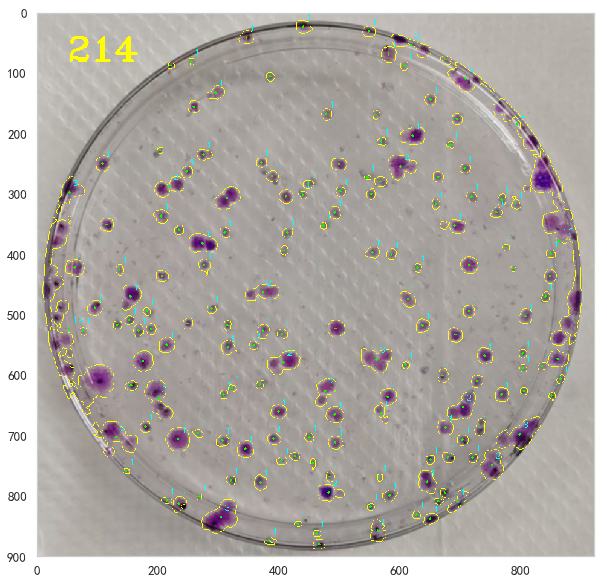

data/cells1\296-1.jpg


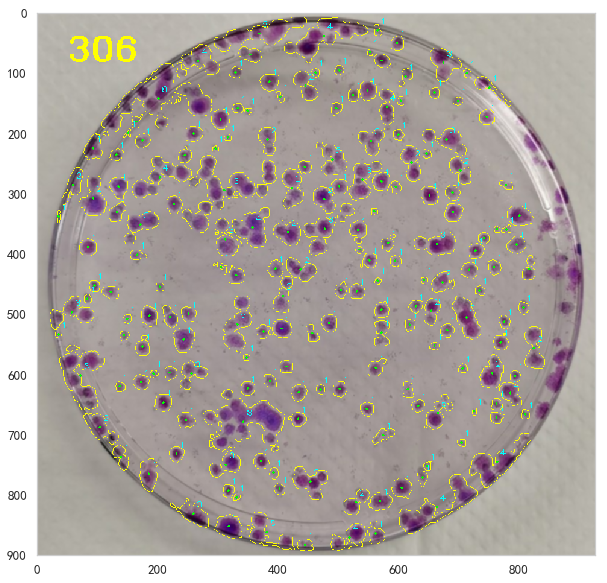

data/cells1\308-1.jpg


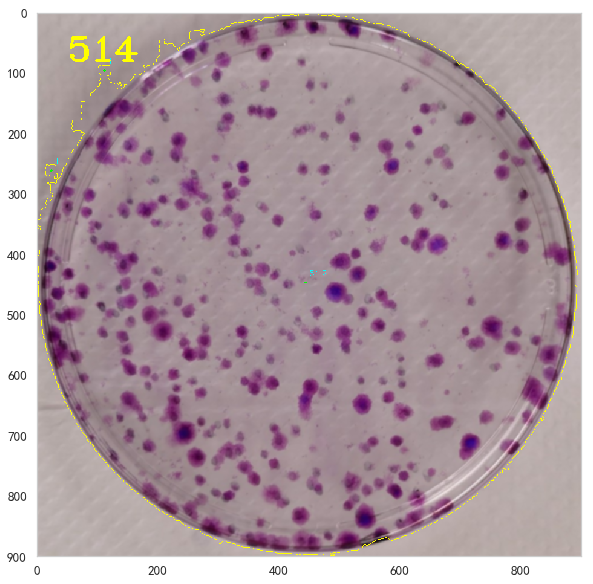

data/cells1\313-1.jpg


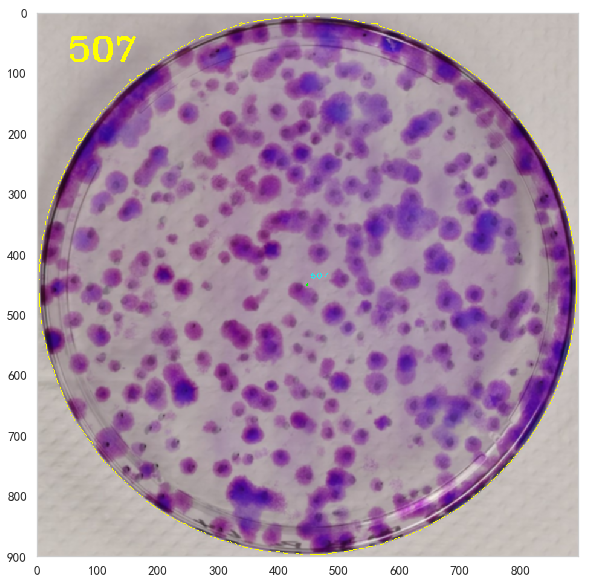

In [13]:
img_files = os.listdir("data/cells1")
imgs = [os.path.join("data/cells1", item) for item in img_files if item.endswith("jpg")] 
count_num =[]
for img in imgs:
    print(img)
    cell_num = cell_population_count(img, config)
    count_num.append(cell_num)
    #print(cell_num)
    #print('='*85)

In [14]:
labeled_num_1 = [item.split("-")[0] for item in img_files if item.endswith("jpg")] 
labeled_num_1 = list(map(int, labeled_num_1))
error = count_metric(count_num, labeled_num_1)
print(error)

[187, 296, 308, 313]

data/cells2\198-2-2.jpg


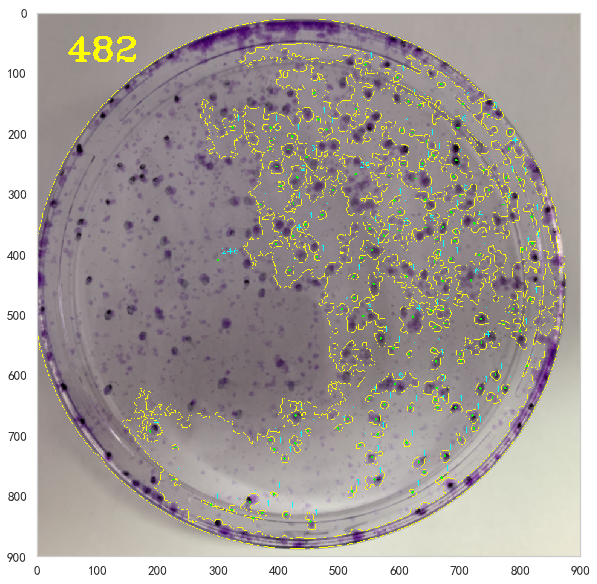

data/cells2\214-2-1.jpg


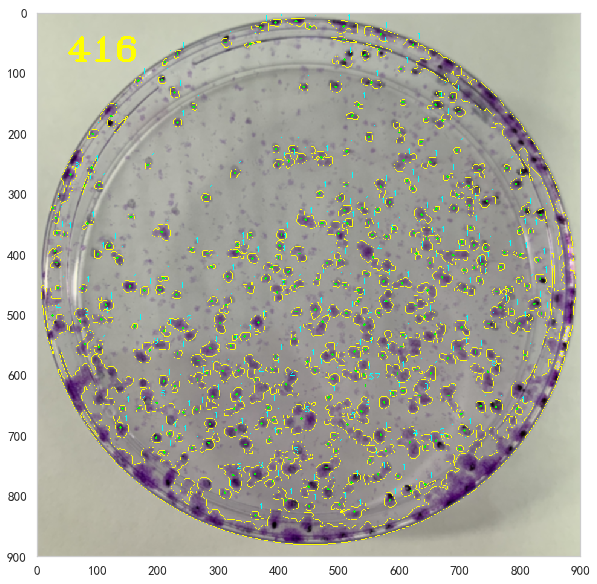

data/cells2\297-1-3.jpg


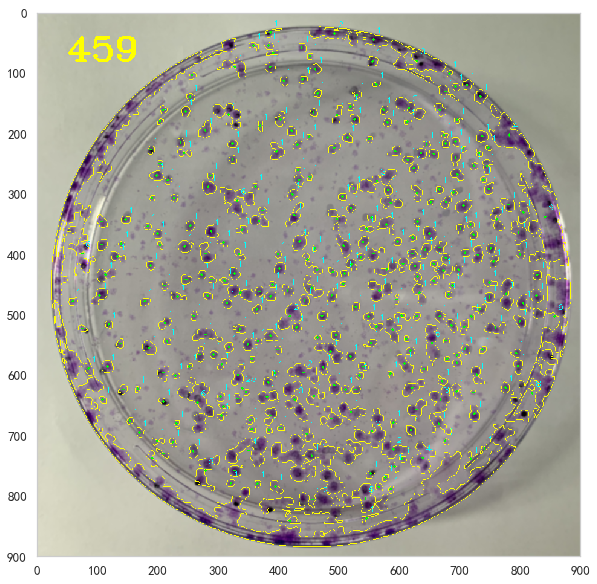

data/cells2\340-1-2.jpg


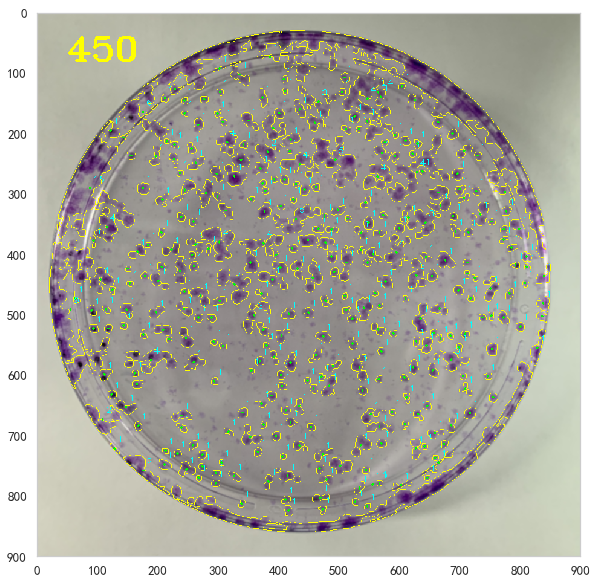

data/cells2\363-1-1.jpg


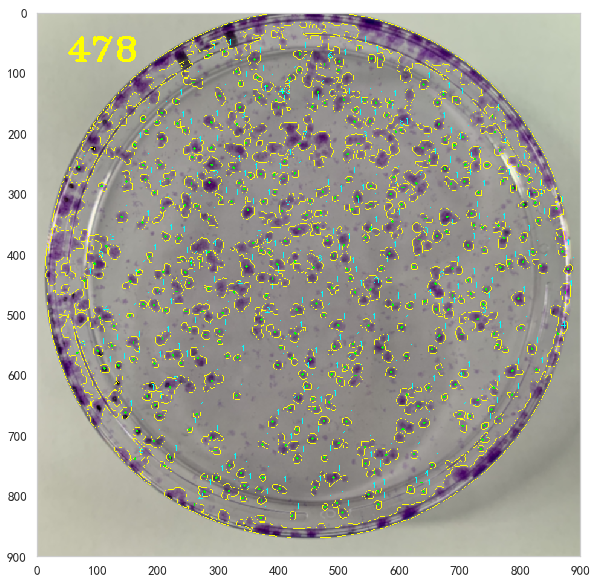

In [17]:
img_files = os.listdir("data/cells2")
imgs = [os.path.join("data/cells2", item) for item in img_files if item.endswith("jpg")] 
count_num =[]
for img in imgs:
    print(img)
    cell_num = cell_population_count(img, config)
    count_num.append(cell_num)
    #print(cell_num)
    #print('='*85)

In [18]:
labeled_num_2 = [item.split("-")[0] for item in img_files if item.endswith("jpg")] 
labeled_num_2 = list(map(int, labeled_num_2))
error = count_metric(count_num, labeled_num_2)
print(error)

[198, 214, 297, 340, 363]

#### 纪录

In [20]:
count_record(config, labeled_num_2, count_num, error)

## 代码重构 软件编写

In [ ]:
# 第一版软件
class HsvFilter:
    """从原始图片经过HSV颜色分割拿到合适的轮廓
    inp: img path
    out: contours of cell populations and resized img
    1) 读入图片
    2）缩放
    3）hsv滤波
    4）初步筛选轮廓
    5）保存处理后的轮廓和图形
    """

    def __init__(self):
        self.img = None
        self.resized_img = None
        self.cnts = None

    def process(self, img_path):
        # 1 读入图片
        self.img = cv2.imread(img_path)
#         self.img = img
        # 2 将图片大小等比缩放到h=900, w=900*scale
        self.resized_img = self.resize(self.img)
        # 3 颜色分割
        mask = self._hsv_creterions(self.resized_img)
        # 4 拿到轮廓
        contours, hierarchy = cv2.findContours(mask,
                                               cv2.RETR_EXTERNAL,
                                               cv2.CHAIN_APPROX_NONE)
        # 5 初步过滤掉一些轮廓
        self.cnts = self._fileter_cnts(contours)

    def _hsv_creterions(self, img, low=[130, 50, 50], up=[200, 250, 200]):
        """这里返回的轮廓是后续群落计数的基础
        直接返回过滤后的全图轮廓
        """
        # 1 颜色转换
        img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        # 2 阈值过滤
        low_purple = np.array(low)
        high_purple = np.array(up)
        mask = cv2.inRange(img_hsv, low_purple, high_purple)

        # 3 膨胀处理二值轮廓掩膜  这一步的处理 抑制了培养皿边缘的噪音
        kernel = np.ones((3, 3), np.uint8)
        mask_dilate = cv2.dilate(mask, kernel, iterations=1)
        # 4 返回过滤后的二值轮廓图像
        return mask_dilate

    def resize(self, img, fixed_size=900):
        h, w, _ = img.shape
        nh, nw = fixed_size, int(fixed_size * (w / h))
        img_resize = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_CUBIC)
        return img_resize

    def _fileter_cnts(self, contours, min_area=8):
        """初步过滤掉一些轮廓
        这里可以进一步添加规则 得到较优质的轮廓
        """
        filtered_cnts = []
        for cnt in contours:
            cnt_area = cv2.contourArea(cnt)
            # cnt_length =  cv2.arcLength(cnt,True)
            # area_length_ratio = cnt_area / cnt_length
            # 所有的轮廓都经过了一次膨胀处理，这里的轮廓面积选择条件要考虑到这一点
            # if cnt_area > min_area and area_length_ratio > 0.5:
            if cnt_area > min_area:
                x, y, w, h = cv2.boundingRect(cnt)
                if 0.25 < w / h < 4:  # 不要很扁的也不要很高的轮廓
                    filtered_cnts.append(cnt)
        return filtered_cnts

    def draw_index(self):
        """画出轮廓的索引便于逐个分析轮廓"""
        img_draw = self.resized_img.copy()
        for idx, cnt in enumerate(self.cnts):  # 这里索引的顺序是self.cnts的顺序

            cv2.drawContours(img_draw, cnt, -1, (255, 255, 0), 1)

            M = cv2.moments(cnt)
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            cv2.circle(img_draw, (cx, cy), 2, (0, 255, 0), 1)
            cv2.putText(img_draw, str(idx), (cx + 5, cy + 5),
                        cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0, 255, 255), 1)


class PopuCntAnalyser:
    """分析每个轮廓中一共有几个群落

    先画一些辅助图以bin_开头
    没有连接在一起的群落可以不用这个函数分析
    """

    def __init__(self, counters, img_src):
        self.cnts = counters  # 传进来所有的轮廓
        self.img = img_src
        self.total_popu = 0
        self.h, self.w, _ = img_src.shape

    def __getitem__(self, index):
        img_draw = self.img  # 每次都把轮廓画到同一张图上
        # 1 首先直接画出 这个 轮廓
        cnt = self.cnts[index]  # 轮廓
        cv2.drawContours(img_draw, cnt, -1, (255, 255, 0), 1)  # 将轮廓cnt画到图img_draw上
        cnt_area = cv2.contourArea(cnt)
        # print(cnt_area)
        if cnt_area < 800:  # 一个小的群落
            popu_num = 1
        elif 1500 <= cnt_area <= 4000:  # 分析连接在一起的轮廓中有几个群落  大轮廓 - 小轮廓 的图
            bin_sub_thresh = self._bin_count_with_hull(cnt)
            popu_num = self.cont_popu_cnts(bin_sub_thresh)
            if popu_num == 0:  # 这个轮廓的计数凹轮廓为0 本身是一个大的圆润的轮廓
                popu_num += 1
        else:
            popu_num = self._bin_count_big_popu(cnt)
        # 4 把群落的个数写在轮廓旁边
        self.draw_number(img_draw, cnt, popu_num)
        # 5 累计所有的群落数
        self.total_popu += popu_num
        # single_popu_conts = cv2.drawContours(img_draw, popu_acount, -1, (255, 0, 0), 1)
        # self._draw_index(cnt, index)
        # plt_show(img_draw, figsize=(20, 15))

    def cont_popu_cnts(self, img_gray, min_area=8):
        """在生成轮廓的同时，过滤一些面积很小的轮廓
        args:
            img_gray:处理过的二值图像，包含用于计数的轮廓
        ret:
            good_cnts: 计数轮廓
        TODO：这个地方还可以做一些优化
        """
        good_cnts = []
        cnts, _ = cv2.findContours(img_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for cnt in cnts:
            area = cv2.contourArea(cnt)
            # print(area)
            if area > min_area:  # 对凹的计数轮廓的面积限定
                good_cnts.append(cnt)
        return len(good_cnts)

    def draw_count_cnts(self, img, cnts):
        """辅助函数：画出计数轮廓 用红色线"""
        cv2.drawContours(img, cnts, -1, (255, 0, 0), 1)

    def draw_number(self, img, cnt, string):
        """将轮廓中群落的个数 写在轮廓旁边"""
        M = cv2.moments(cnt)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        cv2.circle(img, (cx, cy), 2, (0, 255, 0), cv2.FILLED)
        cv2.putText(img, str(string), (cx + 5, cy - 10),
                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 255), 1)

    def draw_index(self, cnt, index):
        """辅助函数：画出轮廓的索引用于后续分析"""
        M = cv2.moments(cnt)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        cv2.circle(self.img, (cx, cy), 2, (0, 255, 0), 1)
        cv2.putText(self.img, str(index), (cx + 5, cy + 5),
                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (0, 255, 255), 1)

    def bin_contours(self, cnt):
        """在二值图上画出轮廓的填充图"""
        img_bin = np.zeros((self.h, self.w))
        draw_bin = cv2.drawContours(img_bin, [cnt], -1, [255, 255, 255], cv2.FILLED)
        return draw_bin

    def bin_enclose_circle(self, cnt):
        """在二值图上画出轮廓内接圆的填充图"""
        img_bin = np.zeros((self.h, self.w))
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(radius)
        draw_bin = cv2.circle(img_bin, center, radius, (255, 255, 255), cv2.FILLED)
        return draw_bin

    def bin_hull(self, cnt):
        """在二值图上画出轮廓凸包的填充图"""
        img_bin = np.zeros((self.h, self.w))
        hull = cv2.convexHull(cnt, False)
        res = cv2.drawContours(img_bin, [hull], -1, (255, 255, 255), cv2.FILLED)
        return res

    def _bin_count_with_circle(self, cnt):
        """使用轮廓外接圆减去轮廓后剩下的图形作为计数轮廓"""
        bin_circle = self.bin_enclose_circle(cnt)
        bin_cnt = self.bin_contours(cnt)
        bin_sub = cv2.subtract(bin_circle, bin_cnt)
        bin_sub = bin_sub.astype(np.uint8)
        _, bin_sub_thresh = cv2.threshold(bin_sub, 50, 255, cv2.THRESH_BINARY)

        return bin_sub_thresh

    def _bin_count_with_hull(self, cnt):
        """使用轮廓外接凸包减去轮廓后剩下的图形作为计数轮廓
        inp：轮廓列表
        out: 凹轮廓二值图
        """
        bin_hull = self.bin_hull(cnt)
        bin_cnt = self.bin_contours(cnt)
        bin_sub = cv2.subtract(bin_hull, bin_cnt)
        bin_sub = bin_sub.astype(np.uint8)  # .astype(np.unit8) np数值类型转化
        _, bin_sub_thresh = cv2.threshold(bin_sub, 50, 255, cv2.THRESH_BINARY)
        return bin_sub_thresh

    def _bin_count_big_popu(self, cnt):
        """这里首要考虑的事情是腐蚀轮廓拉开连在一起的群落"""
        accumulate_popu_num = 0
        bin_cnt = self.bin_contours(cnt)

        kernel = np.ones((3, 3), np.uint8)
        bin_cnt_erode = cv2.erode(bin_cnt, kernel, iterations=4)

        bin_cnt_erode = bin_cnt_erode.astype(np.uint8)
        cnts, _ = cv2.findContours(bin_cnt_erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for cnt in cnts:
            cnt_area = cv2.contourArea(cnt)
            if cnt_area > 6000:  # 如果腐蚀之后轮廓还是很大就直接用面积近似计算
                popu_num = math.ceil(cnt_area / 1200)
                # TODO：面积处理  是不是要做递归处理？
                accumulate_popu_num += popu_num
            else:  # 仍然使用凹轮廓计数
                img_bin = self._bin_count_with_hull(cnt)
                popu_num = self.cont_popu_cnts(img_bin)
                if popu_num == 0:  # 一个很圆润的轮廓可能没有 凹的计数轮廓
                    popu_num += 1
                accumulate_popu_num += popu_num
        return accumulate_popu_num


def cell_population_count(img_path):
    """编写细胞群落计数接口
    inp: RGB图片，
    out: 标记后的图和细胞数"""
    hsv_filter = HsvFilter()
    hsv_filter.process(img_path)
    hsv_cnts, processed_img = hsv_filter.cnts, hsv_filter.resized_img
    popu_analyser = PopuCntAnalyser(hsv_cnts, processed_img)
    for idx in range(len(hsv_cnts)):
        popu_analyser[idx]
    return popu_analyser.total_popu, popu_analyser.img